# Анализ данных о продажах видеоигр

## Введение

Интернет-магазин «Стримчик» продаёт по всему миру
компьютерные игры. Из открытых источников доступны исторические данные о
продажах игр, оценки пользователей и экспертов, жанры и платформы
(например, Xbox или PlayStation). Необходимо выявить определяющие успешность
игры закономерности. Это позволит сделать ставку на потенциально популярный
продукт и спланировать рекламные кампании.
Предоставлены данные до 2016 года, сейчас декабрь 2016 г., и планируется кампания на 2017-й.

Примечание:
В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating
Board) — это ассоциация, определяющая возрастной рейтинг компьютерных
игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную
категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для
подростков».


План исследования:
* Подготовка данных;
* Исследование данных в разрезе периодов, платформ;
* Выбор актуального периода для анализа и поиск наиболее перспективных платформ и жанров;
* Портрет пользователя по регионам;
* Проверка гипотез.

## Изучение данных

In [1]:
import pandas as pd
import re
import datetime as dt
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats as st

In [ ]:
data = pd.read_csv('/datasets/games.csv')
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


**Вывод**

Итак, в таблице 11 столбцов. Согласно документации:
* `Name` — название игры
* `Platform` — платформа
* `Year_of_Release` — год выпуска
* `Genre` — жанр игры
* `NA_sales` — продажи в Северной Америке (миллионы проданных копий)
* `EU_sales` — продажи в Европе (миллионы проданных копий)
* `JP_sales` — продажи в Японии (миллионы проданных копий)
* `Other_sales` — продажи в других странах (миллионы проданных копий)
* `Critic_Score` — оценка критиков (максимум 100)
* `User_Score` — оценка пользователей (максимум 10)
* `Rating` — рейтинг от организации ESRB (англ. Entertainment Software Rating
Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает
им подходящую возрастную категорию.

Основные наблюдения:
* Для столбцов `Year_of_Release`, `Critic_Score`, `User_Score` явно используются не подходящие типы данных
* Количество значений в столбцах различается. Значит, в данных есть пропущенные значения.
* Названия столбцов не соответствует нотации

## Предобработка данных

### Форматирование таблицы

In [4]:
data.columns = data.columns.str.lower()
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### Обработка пропусков

In [5]:
data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

In [6]:
data.loc[data['year_of_release'].isna() | data['name'].isna() | data['genre'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.0,tbd,E10+
16405,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16448,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Видно, что в строках с пропусками года релиза есть еще пропуски в других параметрах. Общее количество пропусков в этих колонках 1.6%. С учетом задачи определить актуальный период для анализа принято решение удалить пропущенные значения в столбцах `name`, `genre`, `year_of_release`.

In [7]:
data.dropna(subset=['name', 'genre', 'year_of_release'], inplace=True)

In [8]:
data.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         6605
rating             6676
dtype: int64

В столбцах `critic_score`, `user_score` присутствует большое количество пропусков, удаление их нецелесообразно, заполнить их исходя из имеющихся данных невозможно. 
Кроме того в столбце `user_score` помимо явных пропусков содержатся аббревиатуры 'tbd' (будет определена позднее), для наших целей это равносильно NaN. 
Таким образом, принято решение заменить пропуски по данным столбцам на -1.

In [9]:
data['user_score'].fillna(-1, inplace=True)
data['critic_score'].fillna(-1, inplace=True)
data.replace('tbd', -1, inplace=True)

В столбце `rating` во-первых присутствуют старые обозначения K-A (kids to Adults), для которых в настоящее время используется обозначение E (Everyone). Во-вторых, присутствует много пропусков, вероятно, так как рейтинг предназначен для США и Канады. Пропуски можно заменить на RP (Rating Pending)

In [10]:
data['rating'].replace('K-A', 'E', inplace=True)
data['rating'].fillna('RP', inplace=True)

In [11]:
data['rating'].value_counts()

RP      6677
E       3924
T       2905
M       1536
E10+    1393
EC         8
AO         1
Name: rating, dtype: int64

In [12]:
data.isna().sum()

name               0
platform           0
year_of_release    0
genre              0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score       0
user_score         0
rating             0
dtype: int64

### Преобразование типов данных

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
name               16444 non-null object
platform           16444 non-null object
year_of_release    16444 non-null float64
genre              16444 non-null object
na_sales           16444 non-null float64
eu_sales           16444 non-null float64
jp_sales           16444 non-null float64
other_sales        16444 non-null float64
critic_score       16444 non-null float64
user_score         16444 non-null object
rating             16444 non-null object
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


Приведем столбец `user_score` к типу `float` для возможности совершать арифметические операции.

In [14]:
data['user_score'] = data['user_score'].astype('float32')

Приведем столбец `critic_score` к типу `int`:

In [15]:
data['critic_score'] = data['critic_score'].astype('int32')

Приведем столбец `year_of_release` к целочисленному типу, так как он хранит информацию только о годе выпуска

In [16]:
data['year_of_release'] = data['year_of_release'].astype('int32')

Столбцы `platform`, `genre` и `rating` хранят очень ограниченное количество значений, повторяющихся тысячи раз. Для оптимизации памяти приведем эти к столбцы к типу `category`

In [17]:
data['platform'].nunique()

31

In [18]:
data['genre'].nunique()

12

In [19]:
data['rating'].nunique()

7

In [20]:
data['platform'] = data['platform'].astype('category')
data['genre'] = data['genre'].astype('category')
data['rating'] = data['rating'].astype('category')

Посмотрим что получилось в результате преобразований:

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
name               16444 non-null object
platform           16444 non-null category
year_of_release    16444 non-null int32
genre              16444 non-null category
na_sales           16444 non-null float64
eu_sales           16444 non-null float64
jp_sales           16444 non-null float64
other_sales        16444 non-null float64
critic_score       16444 non-null int32
user_score         16444 non-null float32
rating             16444 non-null category
dtypes: category(3), float32(1), float64(4), int32(2), object(1)
memory usage: 1014.0+ KB


### Расчет вспомогательных значений

Посчитаем суммарные продажи по игре во всех регионах и запишим их в отдельный столбец.

In [22]:
data['total_sales'] = data.apply(lambda row: row['na_sales'] + row['eu_sales'] + row['jp_sales'] + row['other_sales'], axis=1)

In [23]:
data.head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1,-1.0,RP,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1,-1.0,RP,31.38
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,-1,-1.0,RP,30.26
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89,8.5,E,29.80
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58,6.6,E,28.91
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87,8.4,E,28.32
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,-1,-1.0,RP,28.31


## Исследовательский анализ данных

### Рассмотрим выпуск игр по годам

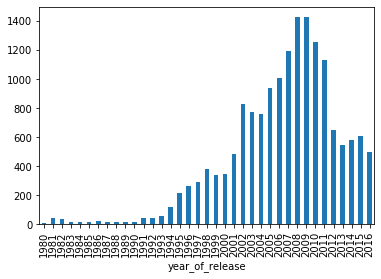

In [24]:
data.groupby('year_of_release')['name'].count().plot(kind='bar')

Начиная от 1980 и до 2009 количество выпускаемых игр в год росло и на пике, в 2008-2009, выпускалось до 1400 игр. Однако затем, количество игр снизилось. Возможная причина - в следствии удорожания разработки.

### Рассмотрим продажи по платформам

Найдем лидеров по суммарным продажам за все время

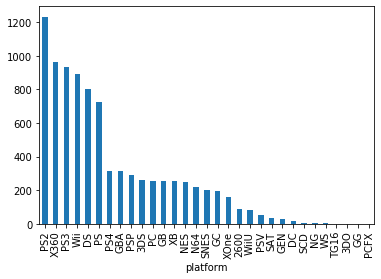

In [25]:
data.groupby('platform')['total_sales'].sum().sort_values(ascending=False).plot(kind='bar')

Игры на платформах
* PS2
* X360
* PS3
* Wii
* DS
* PS

с большим отрывом являются лидерами по суммарным продажам

Далее построим сводную таблицу продаж по годам, отсортируем по суммарным продажам и выберим платформы с суммарными продажами более 200 млн проданных копий.

In [26]:
data_pivot = data.pivot_table(index='platform', columns='year_of_release', values='total_sales', aggfunc='sum', margins=True, fill_value=0).sort_values(by='All', ascending=False).query('(All > 200)').drop('All').drop(columns=['All'])
data_pivot

year_of_release,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
platform,,,,,,,,,,,,,,,,,,,,,
PS2,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,75.99,53.90,26.40,5.64,0.45,0.00,0.00,0.00,0.00,0.00
X360,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,95.41,135.26,120.29,170.03,143.84,99.74,88.58,34.74,11.96,1.52
PS3,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,73.19,118.52,130.93,142.17,156.78,107.36,113.25,47.76,16.82,3.60
Wii,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,152.77,171.32,206.97,127.95,59.65,21.71,8.59,3.75,1.14,0.18
DS,0.0,0.0,0.0,0.00,0.00,0.02,0.00,0.00,0.00,0.00,...,146.94,145.31,119.54,85.02,26.18,11.01,1.54,0.00,0.00,0.00
PS,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
PS4,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,25.99,100.00,118.90,69.25
GBA,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,3.40,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
PSP,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,46.93,34.55,37.78,35.04,17.82,7.69,3.14,0.24,0.12,0.00


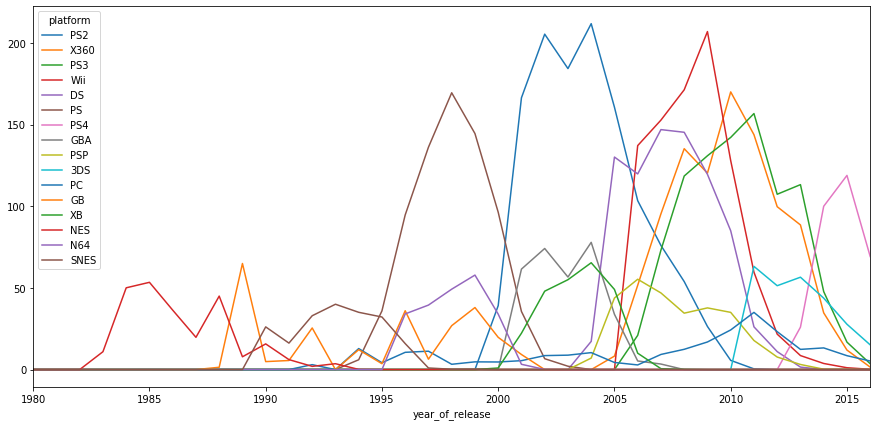

In [27]:
data_pivot.T.plot(figsize=(15,7))

**Вывод** 

В топе продаж игры на платформах PS2, PS3 и X360. Однако, как видно на графике, по ним и другим платформам уходящего поколения наблюдается существенно снижение продаж к 2016 году. При этом игры на платформах более нового поколения (PS4 и 3DS) закономерно имеют большие продажи к 2016 году. Кроме них, существенные продажи имеет платформа PC.

Исходя из графика срок жизни платформы составляет около 5 лет. Для отдельных платформ (X360, PS2, PS3, Wii) этот срок составляет 7-10 лет.

Очевидно, что тренды и вкусы потребителей существенно менялись за десятилетия разработки игр, и то, что было успешно в 80х или 90х маловероятно будет пользоваться большим спросом в 2017. Кроме того, "срок жизни" даже для топовых платформы составляет около 10 лет, а для большинства платформ не превышает нескольких лет. Таким образом, для дальнейшего анализа и прогнозирования бизнеса с учетом актуальных трендов целесообразней взять данные за 2 года.

In [28]:
data_actual = data.query('year_of_release >= 2015')
data_actual.shape[0]

1108

Определим топ платформ по суммарным продажам игр за последние 2 года

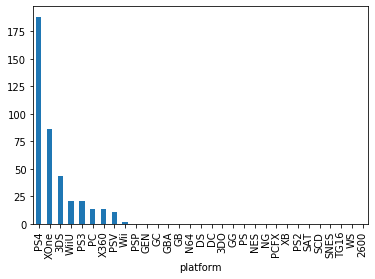

In [29]:
data_actual.groupby('platform')['total_sales'].sum().sort_values(ascending=False).plot(kind='bar')

Построим boxplot по глобальным продажам игр в разбивке по платформам

[Text(0.5, 1.0, 'Глобальные продажи игр по платформам 2015-2016')]

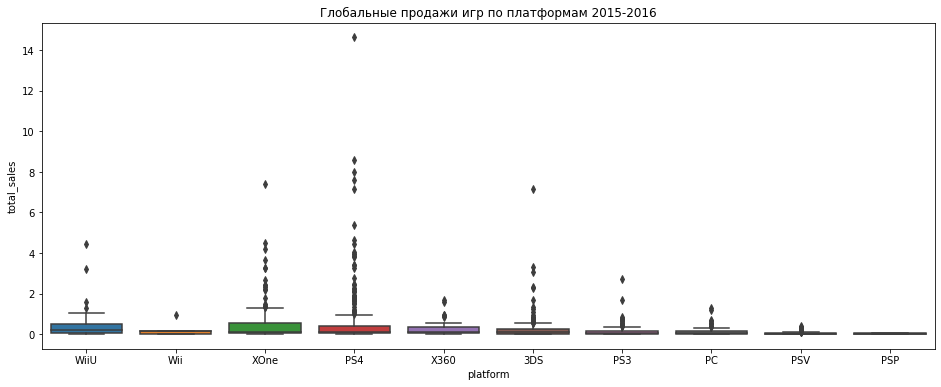

In [30]:
plt.figure(figsize=(16, 6))
my_order = data_actual.groupby('platform')['total_sales'].median().sort_values(ascending=False).dropna().index
ax = sns.boxplot(x="platform", y="total_sales", data=data_actual, order=my_order)
ax.set(title='Глобальные продажи игр по платформам 2015-2016')

[(0, 1.4)]

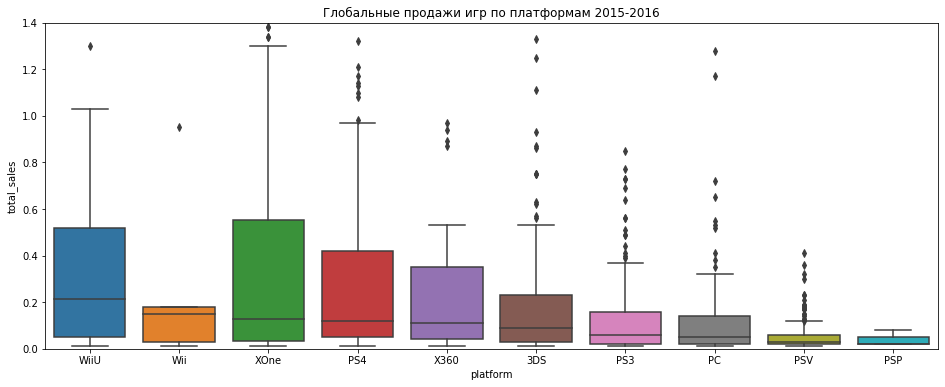

In [31]:
plt.figure(figsize=(16, 6))
my_order = data_actual.groupby('platform')['total_sales'].median().sort_values(ascending=False).dropna().index
ax = sns.boxplot(x="platform", y="total_sales", data=data_actual, order=my_order)
ax.set(title='Глобальные продажи игр по платформам 2015-2016')
ax.set(ylim=(0,1.4))

**Вывод**

Подавляющее большинство игр на всех платформах имеют продажи менее 200 тыс копий (медианное значение). При этом наблюдается большое количество выбросов, игр, продажи которых, существенно превышают остальные. Чем более популярна платформа, тем больший разброс наблюдается по продажам, так как вероятно большее количество игровых студий заняты выпуском игр разного бюджета и качества. Несмотря на то, что платформа PS4 является лидером по суммарным продажам игр за последние два года, по медианному значению продаж она находится только на 4м месте. Это обусловлено бОльшим количеством выбросов  по сравнению с другими платформами (вплоть до $14.6 млн)

### Влияние отзывов пользователей и критиков  на продажи

Рассмотрим, как влияют на продажи внутри самой популярной платформы (PS4) отзывы пользователей и критиков.

Сделаем срез данных по платформе PS4

In [32]:
ps4 = data_actual.query('(platform == "PS4") & (critic_score > 0) & (user_score > 0)')

Посчитаем коэффициент корреляции и построим диаграмму рассеяния для оценок критиков

In [33]:
ps4['total_sales'].corr(ps4['critic_score'])

0.3920741369660568

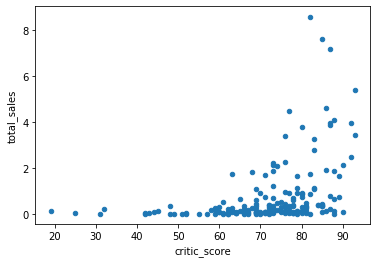

In [34]:
ps4.plot(x='critic_score', y='total_sales', kind='scatter')

Слабая зависимость прослеживается при оценках выше 70

In [35]:
ps4['total_sales'].corr(ps4['user_score'])

-0.06436843180510407

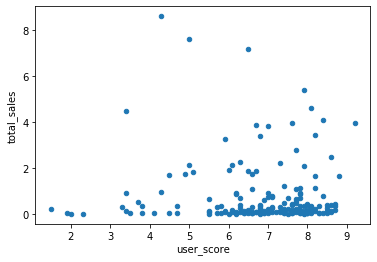

In [36]:
ps4.plot(x='user_score', y='total_sales', kind='scatter')

Корреляция между оценками пользователей и продажами очень низкая или отсутствует

Проверим корреляцию для нескольких других платформ

,XOne,3DS,WiiU
Корреляция между оценками пользователей и продажами,-0.068684,0.240477,0.354987
Корреляция между оценками критиками и продажами,0.422519,0.177575,0.325674


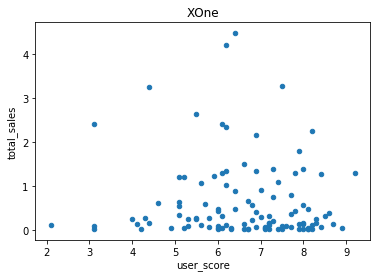

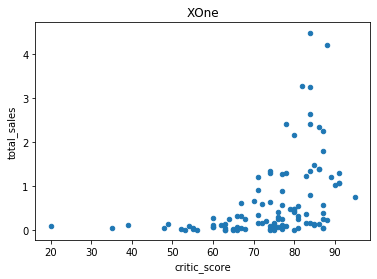

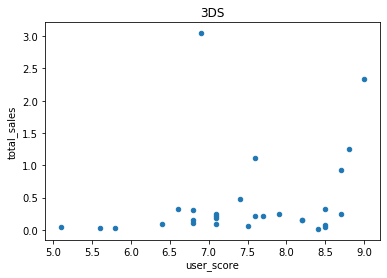

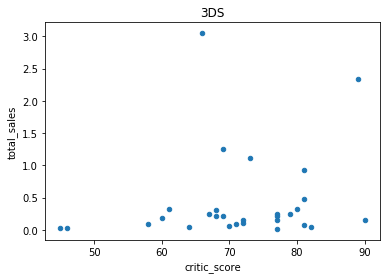

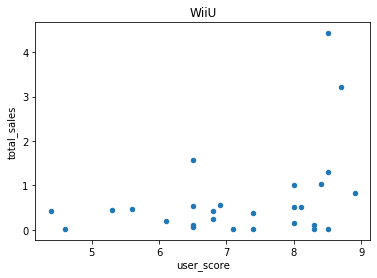

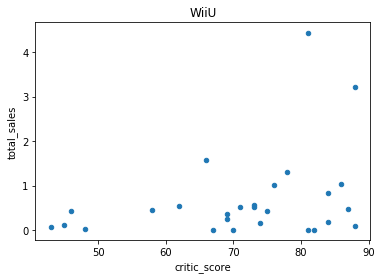

In [37]:
platforms = ['XOne', '3DS', 'WiiU']
platforms_user_score_corr = []
platforms_critic_score_corr = []
for platform in platforms:
    platform_data = data_actual.query('(platform == @platform) & (critic_score > 0) & (user_score > 0)')
    
    platform_data.plot(x='user_score', y='total_sales', kind='scatter', title=platform)
    platform_data.plot(x='critic_score', y='total_sales', kind='scatter', title=platform)
    
    platforms_user_score_corr.append(platform_data['total_sales'].corr(platform_data['user_score']))
    platforms_critic_score_corr.append(platform_data['total_sales'].corr(platform_data['critic_score']))

pd.DataFrame(
    [platforms_user_score_corr, platforms_critic_score_corr],
    columns=platforms,
    index=['Корреляция между оценками пользователей и продажами', 'Корреляция между оценками критиками и продажами']
)

**Вывод**

Оценки критиков и пользователей слабо влияют на суммарные продажи игры

### Рассмотрим продажи по жанрам игр

Посмотрим на общее распределение игр по жанрам в контексте суммарных продаж по ним

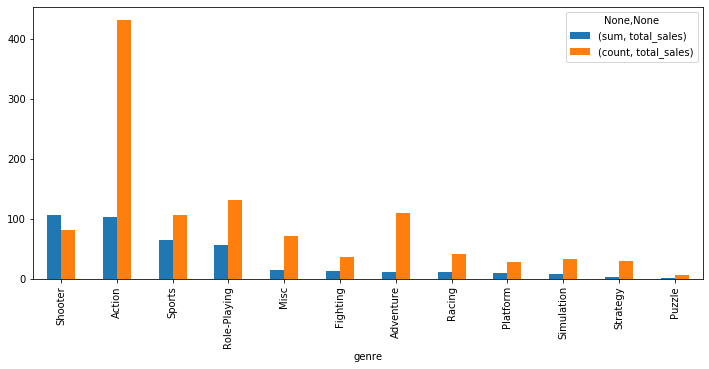

In [38]:
data_actual.pivot_table(index='genre', values='total_sales', aggfunc=['sum', 'count']).sort_values(('sum','total_sales'), ascending=False).plot(kind='bar', figsize=(12,5))

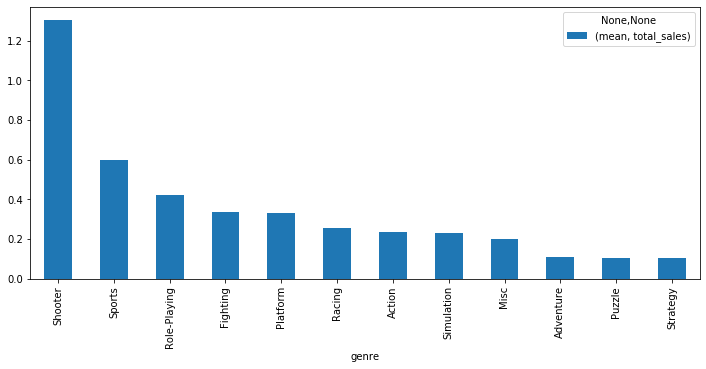

In [39]:
data_actual.pivot_table(index='genre', values='total_sales', aggfunc=['mean']).sort_values(('mean','total_sales'), ascending=False).plot(kind='bar', figsize=(12,5))

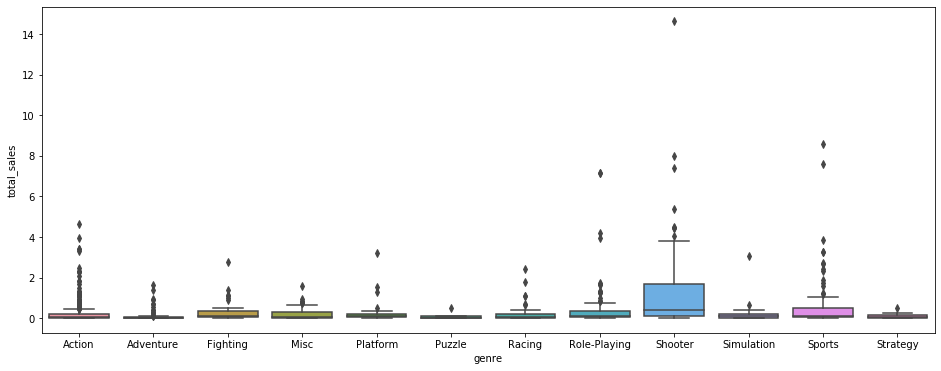

In [40]:
plt.figure(figsize=(16, 6))
sns.boxplot(x="genre", y="total_sales", data=data_actual)

[(0, 4)]

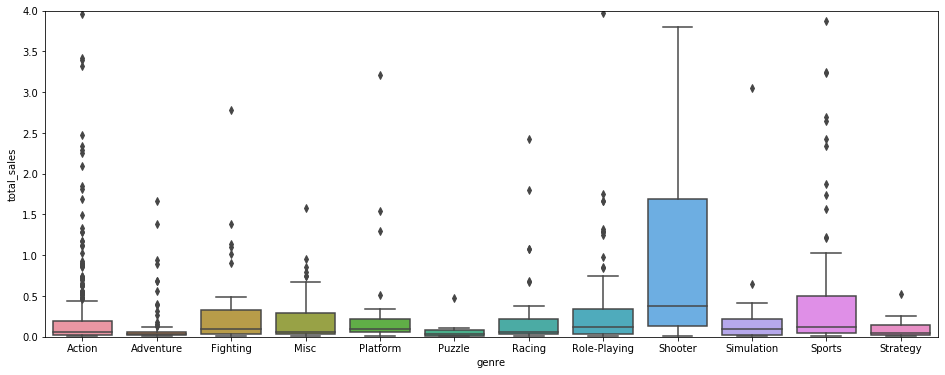

In [41]:
plt.figure(figsize=(16, 6))
ax = sns.boxplot(x="genre", y="total_sales", data=data_actual)
ax.set(ylim=(0, 4))

**Вывод** 

Самым популярным жанром является Action. Однако жанр Shooter опережает его по суммарным и удельным продажам. Несмотря на то, что для жанра Shooter наблюдаются выбросы вплоть до $14млн, медианные продажи и продажи 75% игр в этом жанре существенно превышают аналогичные показатели по остальным жанрам. Наименее прибыльные и малопопулярными являются жанры Strategy и Puzzle.


## Портрет пользователя

Рассмотрим представленные данные в разрезе регионов (NA, EU, JP)

### Популярные платформы

**Регион NA**

In [42]:
na_sales_by_platform = data_actual.groupby('platform')['na_sales'].sum().sort_values(ascending=False).reset_index()
na_sales_by_platform['platform'] = na_sales_by_platform['platform'].astype('object')
na_sales_by_platform['platform'].where(~(na_sales_by_platform['platform'].index > 4), 'other platform', inplace=True)
na_sales_by_platform = na_sales_by_platform.groupby('platform').sum()
na_sales_by_platform['na_sales %'] = na_sales_by_platform.apply(lambda x: round(x/x.sum()*100,1))
na_sales_by_platform.sort_values(by='na_sales', ascending=False)

,na_sales,na_sales %
platform,,
PS4,63.86,42.1
XOne,50.30,33.1
other platform,10.41,6.9
3DS,10.31,6.8
WiiU,8.86,5.8
X360,8.05,5.3


Text(0.5, 1.0, 'na_sales by platform')

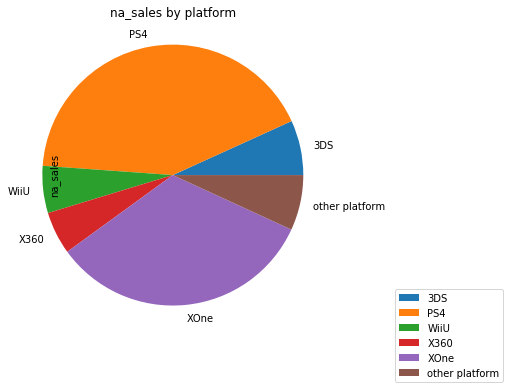

In [43]:
ax = na_sales_by_platform.groupby('platform').sum().plot.pie(y='na_sales', radius=1.5,)
plt.legend(
    bbox_to_anchor=(1.5,0), 
)
plt.title('na_sales by platform', pad=50)

Как и ожидалось в северной америке большой популярностью пользуются родные приставки от Microsoft (XBox). Однако игры для японской платформы PS4 имеют наибольшие продажи. В целом игры для платформ японских производителей Sony и Nintendo суммарно имеют больший рынок в регионе

**Регион EU**

In [44]:
eu_sales_by_platform = data_actual.groupby('platform')['eu_sales'].sum().sort_values(ascending=False).reset_index()
eu_sales_by_platform['platform'] = eu_sales_by_platform['platform'].astype('object')
eu_sales_by_platform['platform'].where(~(eu_sales_by_platform['platform'].index > 4), 'other platform', inplace=True)
eu_sales_by_platform = eu_sales_by_platform.groupby('platform').sum()
eu_sales_by_platform['eu_sales %'] = eu_sales_by_platform.apply(lambda x: round(x/x.sum()*100,1))
eu_sales_by_platform.sort_values(by='eu_sales', ascending=False)

,eu_sales,eu_sales %
platform,,
PS4,83.54,56.5
XOne,28.10,19.0
other platform,12.51,8.5
PC,9.10,6.2
3DS,7.39,5.0
PS3,7.30,4.9


Text(0.5, 1.0, 'eu_sales by platform')

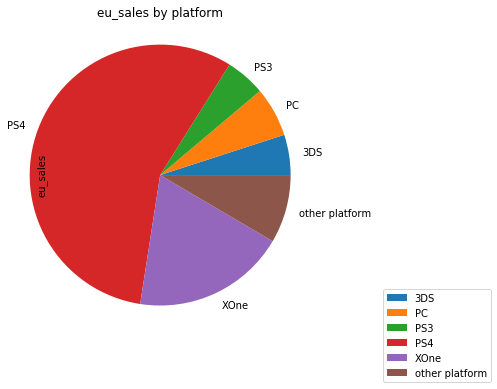

In [45]:
ax = eu_sales_by_platform.groupby('platform').sum().plot.pie(y='eu_sales', radius=1.5,)
plt.legend(
    bbox_to_anchor=(1.5,0), 
)
plt.title('eu_sales by platform', pad=50)

В регионе EU платформа PS4 занимает еще большую долю рынка по сравнению с NA. Примечательно, что вместо платформы старого поколения от Microsoft (X360) в Европе попала в топ платформа старого поколения от Sony (PS3). Кроме того, в регионе EU игры для других платформ и PC имеют значительно большее распростанение по сравнению с NA.

**Регион JP**

In [46]:
jp_sales_by_platform = data_actual.groupby('platform')['jp_sales'].sum().sort_values(ascending=False).reset_index()
jp_sales_by_platform['platform'] = jp_sales_by_platform['platform'].astype('object')
jp_sales_by_platform['platform'].where(~(jp_sales_by_platform['platform'].index > 4), 'other platform', inplace=True)
jp_sales_by_platform = jp_sales_by_platform.groupby('platform').sum()
jp_sales_by_platform['jp_sales %'] = jp_sales_by_platform.apply(lambda x: round(x/x.sum()*100,1))
jp_sales_by_platform.sort_values(by='jp_sales', ascending=False)

,jp_sales,jp_sales %
platform,,
3DS,23.55,44.1
PS4,12.05,22.6
PSV,8.41,15.7
PS3,4.97,9.3
WiiU,4.12,7.7
other platform,0.30,0.6


Text(0.5, 1.0, 'jp_sales by platform')

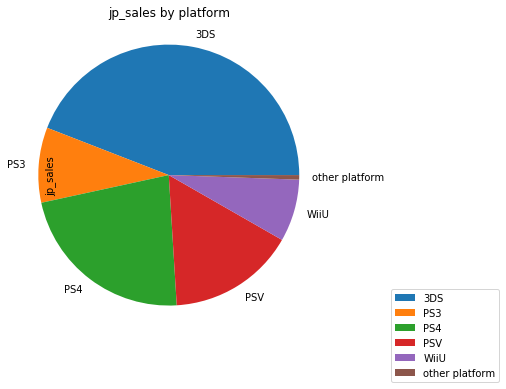

In [47]:
ax = jp_sales_by_platform.groupby('platform').sum().plot.pie(y='jp_sales', radius=1.5,)
plt.legend(
    bbox_to_anchor=(1.5,0), 
)
plt.title('jp_sales by platform', pad=50)

В регионе JP закономерно царит полное господство приставок японских производителей. Причем лидерство удерживает компания Nintendo с платформами 3DS и Wii и более чем половиной рынка. Примечательно, что в регионе JP гораздо большей популярностью пользуются портативные платформы (3DS, PSV), игры для которых, суммарно имеют почти 60% рынка, тогда как для регионов NA и EU единственный представитель портативной платформы (3DS) не поднимался выше 4го места в рейтинге суммарных продаж по играм. Кроме того, доля продаж игр для других платформ ничтожна мала, практически весь рынок поделен между топовыми платформами.

### Популярные жанры

**Регион NA**

In [48]:
na_sales_by_genre = data_actual.groupby('genre')['na_sales'].sum().sort_values(ascending=False).reset_index()
na_sales_by_genre['genre'] = na_sales_by_genre['genre'].astype('object')
na_sales_by_genre['genre'].where(~(na_sales_by_genre['genre'].index > 4), 'other genre', inplace=True)
na_sales_by_genre = na_sales_by_genre.groupby('genre').sum()
na_sales_by_genre['na_sales %'] = na_sales_by_genre.apply(lambda x: round(x/x.sum()*100,1))
na_sales_by_genre.sort_values(by='na_sales', ascending=False)

,na_sales,na_sales %
genre,,
Shooter,48.18,31.7
Action,33.68,22.2
Sports,26.31,17.3
Role-Playing,19.82,13.1
other genre,18.22,12.0
Misc,5.58,3.7


Text(0.5, 1.0, 'na_sales by genre')

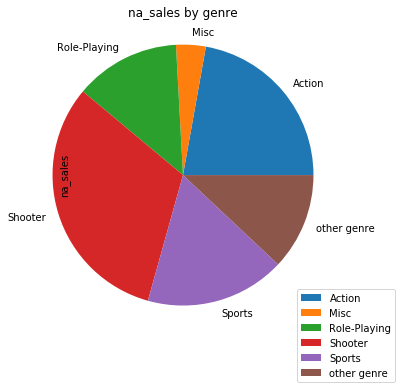

In [49]:
ax = na_sales_by_genre.groupby('genre').sum().plot.pie(y='na_sales', radius=1.5,)
plt.legend(
    bbox_to_anchor=(1.5,0), 
)
plt.title('na_sales by genre', pad=50)

В регионе NA предпочитают жанры Action, Sports и Shooter

**Регион EU**

In [50]:
eu_sales_by_genre = data_actual.groupby('genre')['eu_sales'].sum().sort_values(ascending=False).reset_index()
eu_sales_by_genre['genre'] = eu_sales_by_genre['genre'].astype('object')
eu_sales_by_genre['genre'].where(~(eu_sales_by_genre['genre'].index > 4), 'other genre', inplace=True)
eu_sales_by_genre = eu_sales_by_genre.groupby('genre').sum()
eu_sales_by_genre['eu_sales %'] = eu_sales_by_genre.apply(lambda x: round(x/x.sum()*100,1))
eu_sales_by_genre.sort_values(by='eu_sales', ascending=False)

,eu_sales,eu_sales %
genre,,
Shooter,40.28,27.2
Action,34.82,23.5
Sports,27.82,18.8
other genre,21.29,14.4
Role-Playing,17.21,11.6
Racing,6.52,4.4


Text(0.5, 1.0, 'eu_sales by genre')

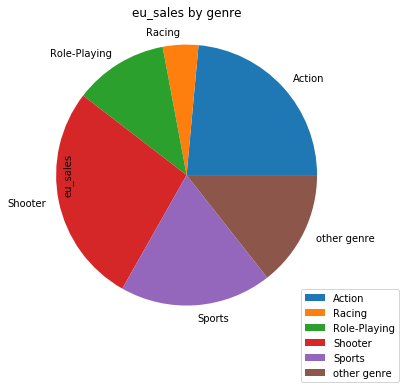

In [51]:
ax = eu_sales_by_genre.groupby('genre').sum().plot.pie(y='eu_sales', radius=1.5,)
plt.legend(
    bbox_to_anchor=(1.5,0), 
)
plt.title('eu_sales by genre', pad=50)

В регионе EU ситуация аналогичная, однако жанр Racing здесь предпочитают больше чем Misc

**Регион JP**

In [52]:
jp_sales_by_genre = data_actual.groupby('genre')['jp_sales'].sum().sort_values(ascending=False).reset_index()
jp_sales_by_genre['genre'] = jp_sales_by_genre['genre'].astype('object')
jp_sales_by_genre['genre'].where(~(jp_sales_by_genre['genre'].index > 4), 'other genre', inplace=True)
jp_sales_by_genre = jp_sales_by_genre.groupby('genre').sum()
jp_sales_by_genre['jp_sales %'] = jp_sales_by_genre.apply(lambda x: round(x/x.sum()*100,1))
jp_sales_by_genre.sort_values(by='jp_sales', ascending=False)

,jp_sales,jp_sales %
genre,,
Action,23.05,43.2
Role-Playing,13.41,25.1
other genre,7.74,14.5
Shooter,3.79,7.1
Misc,3.19,6.0
Adventure,2.22,4.2


Text(0.5, 1.0, 'jp_sales by genre')

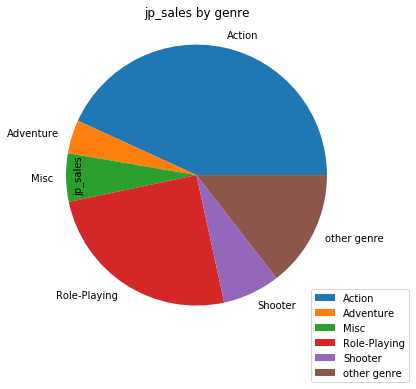

In [53]:
ax = jp_sales_by_genre.groupby('genre').sum().plot.pie(y='jp_sales', radius=1.5,)
plt.legend(
    bbox_to_anchor=(1.5,0), 
)
plt.title('jp_sales by genre', pad=50)

В регионе JP картина сильно отличается - более четверти рынка занимают Role-Playing. Жанр Action занимает примерно в два раза больше рынка по сравнению с другими регионами. Жанр Shooter также очень популярен в регионе, однако в топ не вошел жанр Sport. Последнее место в топе занимает Adventure.

### Влияние рейтинга ESRB на продажи

Для оценки влияния рейтинга зададим порядок категорий рейтинга от (EC) Early childhood до (AO) Adults Only 18+ и найдем суммарные продажи по регионам для каждого рейтинга

In [54]:
rating_order = ['EC', 'E', 'E10+', 'T', 'M', 'AO', 'RP']
data_actual['rating'] = pd.Categorical(data_actual['rating'], categories=rating_order, ordered=True)
sales_by_esrb = data_actual.pivot_table(index='rating', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')

sales_by_esrb = sales_by_esrb.apply(lambda x: round(x/x.sum()*100, 1)) # нормализуем значения для сравнения
sales_by_esrb.columns = ['na_sales %', 'eu_sales %', 'jp_sales %']
sales_by_esrb

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,na_sales %,eu_sales %,jp_sales %
rating,,,
EC,0.0,0.0,0.0
E,23.5,9.8,17.5
E10+,7.8,6.1,11.8
T,13.7,14.4,15.1
M,30.8,8.0,31.0
AO,0.0,0.0,0.0
RP,24.1,61.6,24.7


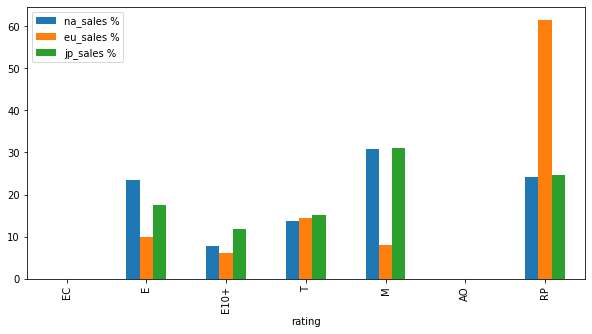

In [55]:
sales_by_esrb.plot(kind='bar', figsize=(10,5))

Исходя из графика можно сделать вывод о том, что рейтинг игры влияет на продажи. Больше всего во всех регионах продажи принести игры с рейтингом M. Принимая во внимание, что рейтинг ESRB применим для США и Канады рассмотрим регион NA отдельно

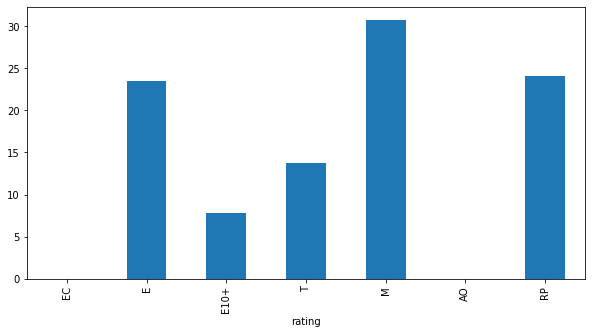

In [56]:
sales_by_esrb['na_sales %'].plot(kind='bar', figsize=(10,5))

Наиболее популярны игры около пограничных категорий: E (для всех) и M (для взрослых), на них приходится более половины всех продаж.

**Вывод**

* Существуют различия в предпочтениях пользователей регионов. Однако в целом, предпочтения пользователей регионов NA и EU похожи.
* В NA и JP предпочитают платформы своего производства.
* Платформа PS4 является лидером по продажам игр в регионах NA и EU.
* В регионе JP предпочтения пользователей сильно отличаются от NA и EU. В регионе JP предпочитают портативные платформы. Рынок почти полностью поделен между основными популярными платформами.
* Наиболее популярными жанрами в регионах NA и EU являются Shooter, Action и Sport. В регионе JP - Action и Role-Playing.
* Влияние рейтинга ESRB определенно прослеживается. Однако учитывая его применимость только для региона NA стоит рассматривать только этот регион. Наибольшими продажами отличаются игры рейтингов E и M.

## Проверка гипотез

### Гипотеза 1

**Нулевая гипотеза:** средние значения пользовательских рейтингов платформ Xbox One и PC *равны*

**Альтернативная гипотеза:** средние значения пользовательских рейтингов платформ Xbox One и PC *отличаются*

Для проверки гипозеты воспользуемся методом `ttest_ind` и зададим критический уровень статистической значимости 5%

In [57]:
xboxone_user_score = data_actual.query('platform == "XOne"')['user_score'].dropna()
pc_user_score = data_actual.query('platform == "PC"')['user_score'].dropna()

alpha = .05

results = st.ttest_ind(xboxone_user_score, pc_user_score)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-value: 0.32588724877729613
Не отвергаем нулевую гипотезу


Исходя из полученного p-value мы не можем отвергнуть нулевую гипотезу

## Гипотеза 2

Аналогично проверим гипотезу о равенстве средних пользовательских рейтингов жанров Action и Sports

**Нулевая гипотеза:** средние значения пользовательских рейтингов жанров Action и Sports *равны*

**Альтернативная гипотеза:** средние значения пользовательских рейтингов жанров Action и Sports *отличаются*

In [58]:
action_user_score = data_actual.query('genre == "Action"')['user_score'].dropna()
sports_user_score = data_actual.query('genre == "Sports"')['user_score'].dropna()

alpha = .05

results = st.ttest_ind(action_user_score, sports_user_score)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-value: 0.002606872747503855
Отвергаем нулевую гипотезу


Полученное значение p-value гораздо меньше заданного уровная статистической значимости, то есть вероятность равенства средних значений пользовательских рейтингов жанров Action и Sports крайне мала. 

Таким образом, необходимо отвергнуть нулевую гипотезу в пользу альтернативной.

## Вывод

* В топе продаж за все время игры на платформах PS2, PS3 и X360. Однако, срок жизни платформы составляет около 5 лет, в редких случаях до 10 лет. Таким образом игры на платформах более нового поколения (PS4 и 3DS) закономерно имеют большие продажи к 2016 году. Кроме них, существенные продажи имеет платформа PC.

* Подавляющее большинство игр на всех платформах имеют продажи менее 200 тыс копий (медианное значение). При этом наблюдается большое количество выбросов, игр, продажи которых, существенно превышают остальные. Несмотря на то, что PS4 является лидером по суммарным продажам наиболее перспективными являются платформы WiiU и XOne за счет более высоких медианных значений и значений Q3, то есть игры для этих платформ в среднем более прибыльные.

* Оценки критиков и пользователей слабо влияют на суммарные продажи игры

* Самым популярным жанром является Action. Однако жанр Shooter опережает его по суммарным и удельным продажам, что делает его более предпочтительным с точки зрения прибыльности.

* Существуют различия в предпочтениях пользователей регионов. 
 * В NA и JP предпочитают платформы своего производства. 
 * В целом, предпочтения пользователей регионов NA и EU похожи. 
 * В регионе JP предпочтения пользователей сильно отличаются от NA и EU как по платформам, так и по жанрам
 * Влияние рейтинга ESRB корректно отслеживать для региона NA Наибольшими продажами отличаются игры рейтинга E и M

* Гипотеза о равенстве средних пользовательских рейтингов платформ XOne и PC **подтвердилась**.
* Гипотеза о неравенстве средних пользовательских рейтингов жанров Action и Sports **подтвердилась**